In [134]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


In [135]:
df = pd.read_csv('Competitor Listings for Jett-2025-08-06-10-16-11.csv')

#DATA CLEANING AND EXPLORATION
# Check for missing values
missing_summary = df.isnull().sum()
print("Missing values per column:")
print(missing_summary[missing_summary > 0])

# List of columns to drop
cols_to_drop = [
    'Unnamed: 25',
    'Missing Fields List',
    'LDC Places',
    'Agency 2',
    'Agent 4',
    'Agent 3',
    'Agent 2',
    'LDC Places',
    'Yield'
]

# Drop them from the DataFrame
df_cleaned = df.drop(columns=cols_to_drop)

Missing values per column:
Tenant Tag 1            481
Main Tenant              18
Rent                    404
Sale Price              709
Yield                   901
Sale Method               2
Auction / EOI Date      777
Agency 2               2871
Agent 1                 725
Agent 2                1242
Agent 3                2498
Agent 4                2983
Building Size           670
Land Size               968
LDC Places             2879
Source Link URL         505
Missing Fields List    3088
Unnamed: 25            3088
dtype: int64



🔍 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3088 entries, 0 to 3087
Data columns (total 26 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Confidential Record                            3088 non-null   bool   
 1   Property Tag 1                                 3088 non-null   object 
 2   Tenant Tag 1                                   2607 non-null   object 
 3   Property: Title                                3088 non-null   object 
 4   Agency 1                                       3088 non-null   object 
 5   Main Tenant                                    3070 non-null   object 
 6   Rent                                           2684 non-null   object 
 7   Advert Date                                    3088 non-null   object 
 8   Sale Date                                      3088 non-null   object 
 9   Sale Price                         

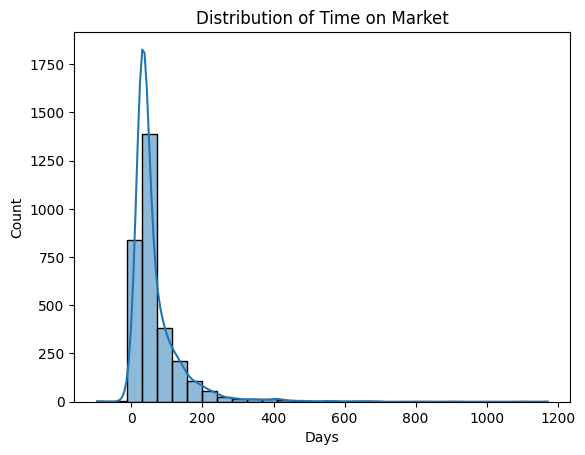

In [136]:
# --- Basic Info ---
print("\n🔍 Dataset Info:")
df.info()

# --- Summary Statistics ---
print("\n📈 Summary Statistics (Numerical Columns):")
print(df.describe())

# --- Data Types ---
print("\n🧬 Data Types:")
print(df.dtypes)

# --- Missing Values Overview ---
print("\n🚨 Missing Values:")
missing_summary = df.isnull().sum()
missing_percent = (missing_summary / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_summary,
    'Missing %': missing_percent.round(2)
})
print(missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing %', ascending=False))

# --- Unique Values per Column ---
print("\n🔢 Unique Values per Column:")
unique_counts = df.nunique().sort_values(ascending=False)
print(unique_counts)

# Ensure date columns are in datetime format
df['Advert Date'] = pd.to_datetime(df['Advert Date'], errors='coerce', dayfirst=True)
df['Sale Date'] = pd.to_datetime(df['Sale Date'], errors='coerce', dayfirst=True)

# Calculate time on market in days
df['Time_on_Market'] = (df['Sale Date'] - df['Advert Date']).dt.days

# Optional: Check distribution
print("\n📊 Time on Market Summary:")
print(df['Time_on_Market'].describe())

sns.histplot(df['Time_on_Market'], bins=30, kde=True)
plt.title('Distribution of Time on Market')
plt.xlabel('Days')
plt.ylabel('Count')
plt.show()

df['Sold_Quickly'] = df['Time_on_Market'] <= 90


In [118]:
# Define target
target = 'Sold_Quickly'

# Example feature selection (customize as needed)
features = [
    'Rent', 'Sale Price', 'Building Size', 'Land Size',
    'Agency 1', 'Main Tenant', 'Sale Method'
]

# Subset the data
X = df[features]
y = df[target]

#CLASSIFICATION MODELING
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Identify column types
numeric_features = ['Rent', 'Sale Price', 'Building Size', 'Land Size']
categorical_features = ['Agency 1', 'Main Tenant', 'Sale Method']

# Clean currency columns
currency_columns = ['Sale Price', 'Rent']

for col in currency_columns:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(r'[\$,]', '', regex=True)  # Remove $ and commas
        .str.strip()
    )
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to float
  # Convert to float

In [137]:
symbol_check = df.apply(lambda col: col.astype(str).str.contains(r'[\$%]', na=False))
rows_with_symbols = symbol_check.any(axis=1)

# Show rows that contain $ or %
df[rows_with_symbols]


,Confidential Record,Property Tag 1,Tenant Tag 1,Property: Title,Agency 1,Main Tenant,Rent,Advert Date,Sale Date,Sale Price,...,Building Size,Land Size,LDC Places,Field Percent Complete,Source Link URL,Transaction History: Transaction History Name,Missing Fields List,Unnamed: 25,Time_on_Market,Sold_Quickly
0,False,Large Format Retail,Showroom,"103 Rankin Street, Forbes NSW 2871",Burgess Rawson,The Reject Shop,"$135,952",2024-09-26,2024-10-21,"$1,930,001",...,1056.0,NaN,NaN,100%,PROPID_172.69,TH-000000,NaN,NaN,25,True
1,False,Retail,Strip Retail,"2 The Crescent, Kingsgrove NSW 2208",My Space Industrial Agents,Kingsmen Barbershop and Apparel,NaN,2024-11-29,2025-01-14,"$2,350,000",...,104.0,NaN,NaN,100%,https://www.realcommercial.com.au/for-sale/pro...,TH-000001,NaN,NaN,46,True
2,False,Automotive,Car Dealerships,"1 Prestige Place, Narre Warren VIC 3805",Colliers,Subaru Berwick,"$643,077",2019-03-12,2019-08-05,"$9,650,000",...,1365.0,3950.00,NaN,100%,Sales Evidence from Jesse (Car Dealerships),TH-000043,NaN,NaN,146,False
3,False,Pubs and Hotels,Pubs,"32 Anzac Avenue, Redcliffe QLD 4020",Savills,QVC,"$1,060,950",2019-06-10,2021-12-01,"$19,290,000",...,NaN,NaN,NaN,100%,NaN,TH-000044,NaN,NaN,905,False
4,False,Automotive,Car Dealerships,"380 Cooper Street, Epping VIC 3076",CBRE,Mercedes-Benz,"$841,500",2019-11-01,2019-12-17,"$12,600,000",...,3610.0,12800.00,NaN,100%,Sales Evidence from Jesse (Car Dealerships),TH-000048,NaN,NaN,46,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3083,False,Childcare and Social Infrastructure,Childcare,"9-13 Alice Street, Cranbrook QLD 4814",Burgess Rawson,Goodstart Early Learning,"$243,955",2025-05-28,2025-06-23,"$5,400,000",...,1.0,2781.00,NaN,100%,Created by Propertybase Automation when Listin...,TH-011977,NaN,NaN,26,True
3084,False,Childcare and Social Infrastructure,Childcare,"21-23 Montrose Avenue, Merrylands NSW 2160",Burgess Rawson,Montessori Academy,"$175,625",2025-07-09,2025-08-01,"$4,200,000",...,1.0,1219.00,65,100%,Created by Propertybase Automation when Listin...,TH-012053,NaN,NaN,23,True
3085,False,Development Site,NaN,"14-16 Atkinson Street, Chadstone VIC 3148",Gross Waddell ICR,Vacant,NaN,2025-01-14,2025-06-17,NaN,...,NaN,3580.00,NaN,100%,https://www.realcommercial.com.au/sold/propert...,TH-012066,NaN,NaN,154,False
3086,False,Office,NaN,"390 High Street, Echuca VIC 3564",Burgess Rawson,Insurance House,"$134,200",2025-07-10,2025-07-29,"$2,175,000",...,392.0,1164.75,NaN,100%,Created by Propertybase Automation when Listin...,TH-012091,NaN,NaN,19,True


In [138]:
# Remove $ and % from all string-type columns
for col in df.columns:
    df[col] = df[col].astype(str).str.replace(r'[\$%]', '', regex=True)


In [139]:
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col], errors='ignore')
    except:
        pass  # Skip columns that aren't meant to be numeric


C:\Users\Jett\AppData\Local\Temp\ipykernel_18152\2611506390.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


In [140]:
# Re-run symbol scan to confirm cleanup
symbol_check = df.apply(lambda col: col.astype(str).str.contains(r'[\$%]', na=False))
print("Remaining columns with $ or %:", symbol_check.any()[symbol_check.any()].index.tolist())


Remaining columns with $ or %: []


In [154]:
for col in X_train.select_dtypes(include='object').columns:
    dollar_values = X_train[col][X_train[col].str.contains(r'\$', na=False)]
    if not dollar_values.empty:
        print(f"\n🧾 Column: {col}")
        print(dollar_values.unique())



🧾 Column: Rent
['$615,000' '$591,300' '$1,365,677' ... '$42,640' '$156,763' '$725,744']

🧾 Column: Sale Price
['$9,100,000' '$45,000,000' '$10,900,000' ... '$31,375,000' '$3,325,000'
 '$15,129,000']


In [155]:
for col in X_train.select_dtypes(include='object').columns:
    count = X_train[col].str.contains(r'\$', na=False).sum()
    if count > 0:
        print(f"{col}: {count} entries with $")


Rent: 2145 entries with $
Sale Price: 1901 entries with $


In [156]:
def clean_currency_column(df, col_name):
    df[col_name] = df[col_name].replace('[\$,]', '', regex=True).replace(',', '', regex=True)
    df[col_name] = pd.to_numeric(df[col_name], errors='coerce')


In [157]:
for col in ['Rent', 'Sale Price']:
    clean_currency_column(X_train, col)
    clean_currency_column(X_test, col)


In [158]:
print(X_train[['Rent', 'Sale Price']].dtypes)
print(X_test[['Rent', 'Sale Price']].dtypes)


Rent          float64
Sale Price    float64
dtype: object
Rent          float64
Sale Price    float64
dtype: object


In [159]:
for col in ['Rent', 'Sale Price']:
    train_has_dollar = X_train[col].astype(str).str.contains(r'\$', na=False).any()
    test_has_dollar = X_test[col].astype(str).str.contains(r'\$', na=False).any()
    print(f"{col} in train contains $: {train_has_dollar}")
    print(f"{col} in test contains $: {test_has_dollar}")


Rent in train contains $: False
Rent in test contains $: False
Sale Price in train contains $: False
Sale Price in test contains $: False


In [160]:
def clean_percent_column(df, col_name):
    df[col_name] = df[col_name].str.replace('%', '', regex=False)
    df[col_name] = pd.to_numeric(df[col_name], errors='coerce')


In [163]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])


In [164]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])


In [166]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()


In [167]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


In [168]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

logreg_pipeline.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [169]:
y_pred = logreg_pipeline.predict(X_test)
y_proba = logreg_pipeline.predict_proba(X_test)[:, 1]


In [170]:
from sklearn.metrics import classification_report

print("📋 Classification Report:")
print(classification_report(y_test, y_pred))


📋 Classification Report:
              precision    recall  f1-score   support

       False       0.57      0.17      0.27       120
        True       0.83      0.97      0.89       498

    accuracy                           0.81       618
   macro avg       0.70      0.57      0.58       618
weighted avg       0.78      0.81      0.77       618



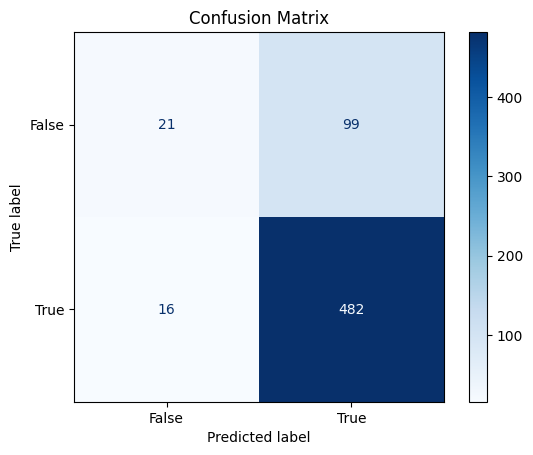

In [171]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(logreg_pipeline, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


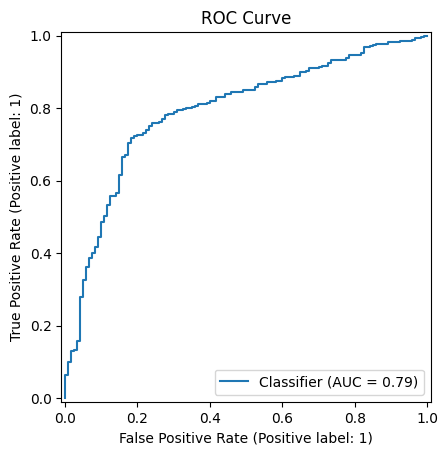

In [172]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve")
plt.show()


In [173]:
feature_names = logreg_pipeline.named_steps['preprocessor'].get_feature_names_out()
coefficients = logreg_pipeline.named_steps['classifier'].coef_[0]

import pandas as pd
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("\n🔍 Top Influential Features:")
print(coef_df.head(10))



🔍 Top Influential Features:
                                        Feature  Coefficient
1709  cat__Main Tenant_United Housing Australia    -1.536241
276    cat__Main Tenant_2 residential tenancies    -1.400027
1040              cat__Main Tenant_Kids Academy    -1.271907
593             cat__Main Tenant_Cheap as Chips    -1.159392
558           cat__Main Tenant_Caltex Australia    -1.097417
579            cat__Main Tenant_Cash Converters    -1.073744
1817              cat__Sale Method_Private Sale    -1.071346
1810                   cat__Sale Method_Auction     1.011998
287                cat__Main Tenant_3 tenancies    -1.010657
1603        cat__Main Tenant_Swanson Industries    -1.010542


In [174]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # reuse the same one with imputation
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])


In [175]:
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]


📋 Random Forest Classification Report:
              precision    recall  f1-score   support

       False       0.61      0.14      0.23       120
        True       0.83      0.98      0.90       498

    accuracy                           0.82       618
   macro avg       0.72      0.56      0.56       618
weighted avg       0.78      0.82      0.77       618



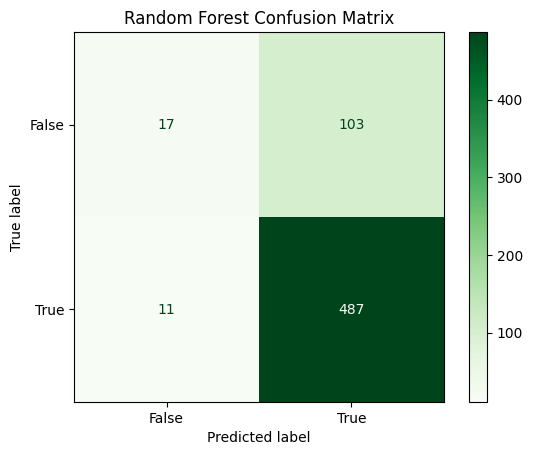

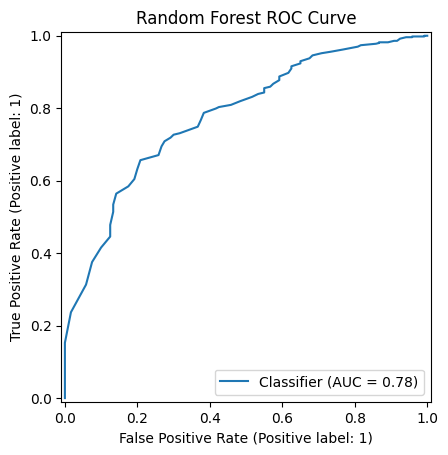

In [176]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

print("📋 Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

ConfusionMatrixDisplay.from_estimator(rf_pipeline, X_test, y_test, cmap='Greens')
plt.title("Random Forest Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba_rf)
plt.title("Random Forest ROC Curve")
plt.show()


In [177]:
import pandas as pd

feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()
importances = rf_pipeline.named_steps['classifier'].feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n🌟 Top Features by Importance:")
print(importance_df.head(10))



🌟 Top Features by Importance:
                                 Feature  Importance
0                              num__Rent    0.088847
1                        num__Sale Price    0.083140
2                     num__Building Size    0.072031
3                         num__Land Size    0.067797
1814  cat__Sale Method_Portfolio Auction    0.033512
1817       cat__Sale Method_Private Sale    0.020913
1812                cat__Sale Method_EOI    0.020800
29          cat__Agency 1_Burgess Rawson    0.012314
975   cat__Main Tenant_Industrial Tenant    0.009890
63                cat__Agency 1_Colliers    0.009641


In [178]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt


In [179]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


In [180]:
tree_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42))
])


📋 Decision Tree Classification Report:
              precision    recall  f1-score   support

       False       0.36      0.76      0.48       120
        True       0.92      0.67      0.77       498

    accuracy                           0.69       618
   macro avg       0.64      0.71      0.63       618
weighted avg       0.81      0.69      0.72       618



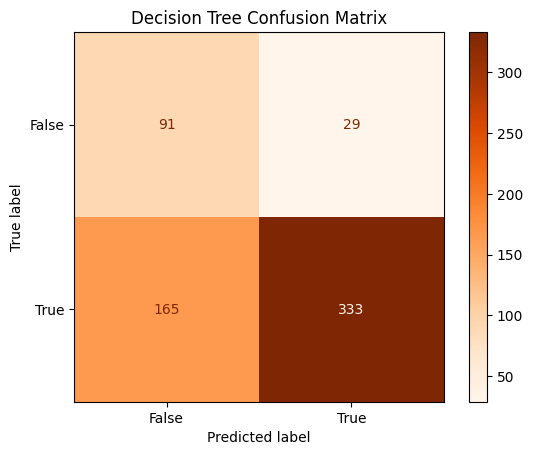

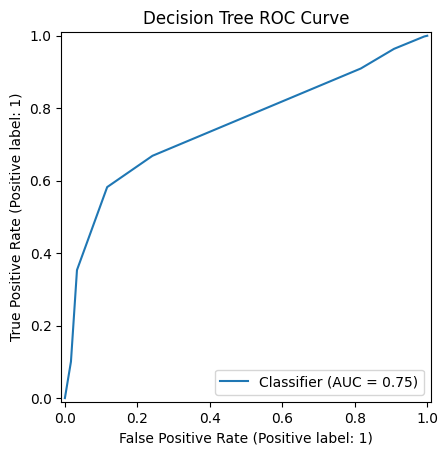

In [181]:
tree_pipeline.fit(X_train, y_train)
y_pred_tree = tree_pipeline.predict(X_test)
y_proba_tree = tree_pipeline.predict_proba(X_test)[:, 1]

print("📋 Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_tree))

ConfusionMatrixDisplay.from_estimator(tree_pipeline, X_test, y_test, cmap='Oranges')
plt.title("Decision Tree Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba_tree)
plt.title("Decision Tree ROC Curve")
plt.show()


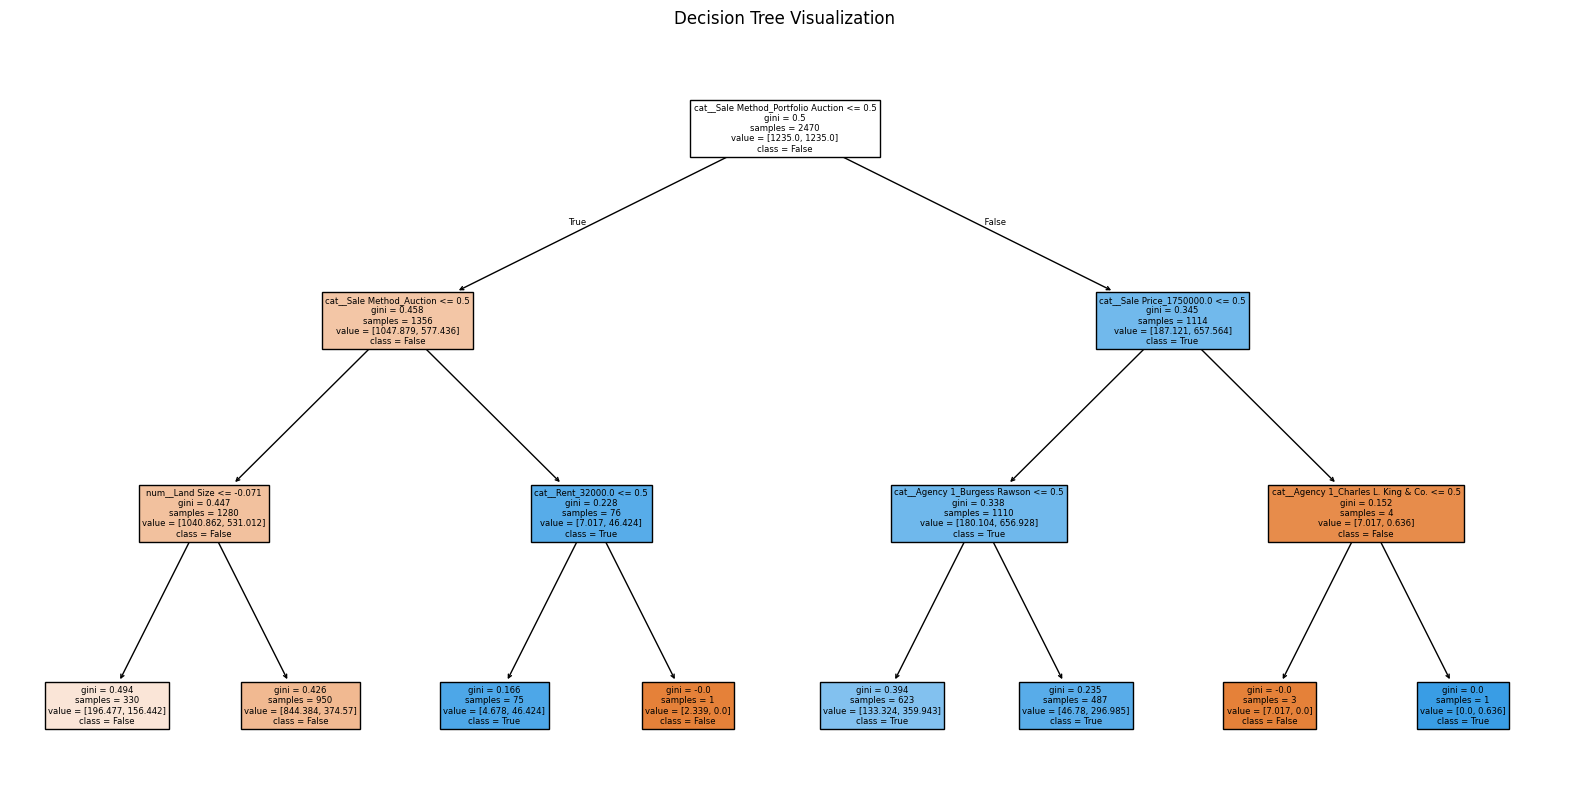

In [182]:
from sklearn.tree import plot_tree

# Fit a standalone tree for visualization
tree_model = DecisionTreeClassifier(max_depth=3, class_weight='balanced', random_state=42)
tree_model.fit(preprocessor.fit_transform(X_train), y_train)

plt.figure(figsize=(20, 10))
plot_tree(tree_model, filled=True, feature_names=preprocessor.get_feature_names_out(), class_names=['False', 'True'])
plt.title("Decision Tree Visualization")
plt.show()
